In [3]:
import preprocess
import sqlite3
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 500)
import warnings
warnings.filterwarnings("ignore")
import scipy
from collections import Counter

### Some functions we might need

In [4]:
def prepre(df):
    df = df.drop(['Date of Discharge', 'Chronic disease',
           'Immune status', 'Foley days', 'CVC days', 'Palliative', 'PH', 
           'Vent days', 'TWA Glucose', 'LOS', 'APACHE II Pred Mort', 'Trop Pred Mort'], axis=1)
    df['Vent mode'] = np.nan
    df['A-a gradient'] = np.nan
    df = df[['Unnamed: 0.1', 'Name', 'CPMRN', 'Date of admission', 'Age', 'Gender',
           'Hospital', 'Surgical status', 'Vent mode', 'GCS', 'Temperature', 'HR', 
            'SpO2', 'SBP', 'MAP', 'RR', 'FiO2', 'PaO2', 'PaCO2', 'pH', 'A-a gradient', 
            'HCO3', 'Hb', 'TLC', 'Platelets', 'K', 'Na', 'Cr', 'Ur', 'T.Bili', 'Urine output',
           'Lactate', 'INR', 'DC Dispo']]
    set_col_names = ['Unnamed: 0', 'Name', 'CPMRN', 'Month of Admission', 'Age', 'Gender',
           'Hospital', 'Surgery', 'Vent mode', 'GCS', 'Temparature', 'HR', 'SpO2',
           'SBP', 'MAP', 'RR', 'FiO2', 'PaO2', 'PaCO2', 'pH', 'A-a gradient',
           'HCO3', 'Hb', 'TLC', 'Platelets', 'K', 'Na', 'Serum Cr', 'Blood Urea',
           'Bili', 'Urine output', 'Lactate', 'INR', 'Survival']
    df.columns = set_col_names
    return df

In [5]:
def selectRows(df, col_name, value_list):
    for i in range(len(value_list)):
        if (i==0):
            temp = df[df[col_name]==value_list[i]]
        else:
            new = df[df[col_name]==value_list[i]]
            temp = pd.concat((new, temp), axis=0, ignore_index=True)
    return temp

In [6]:
def mean_confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    string = str(round(m, 1)) + ' (' + str(round(m-h, 1)) + '-' + str(round(m+h, 1)) +')'
    return string

In [7]:
def median_iqr(data, quartile=50):
    a = np.array(data)
    n = len(a)
    q75, q25 = np.percentile(data, [(50+(quartile/2)) ,(50-(quartile/2))])
    median = np.median(data)
    string = str(round(median, 1)) + ' (' + str(round(q25, 1)) + '-' + str(round(q75, 1)) +')'
    return string

In [8]:
def getSummary(df, y, name):
    count_cols = list(df.columns[[1, 2]])
    num_cols = list(df.columns)
    del num_cols[1:3]
    count = pd.DataFrame([len(df)], ['Count'])
    deaths = pd.DataFrame([(Counter(y)['Expired'])], ['Deaths'])
    counts = df[count_cols].apply(lambda col: Counter(col), axis=0)
    gender = pd.DataFrame(counts.iloc[:,0].dropna())
    gender.columns = [0]
    sur = pd.DataFrame(counts.iloc[:,1].dropna())
    sur.columns = [0]
    medians = pd.DataFrame(df[num_cols].apply(lambda col: mean_confidence_interval(col), axis=0))
    all_pats = pd.concat((count, deaths, gender, sur, medians), axis=0)
    all_pats.columns = [name]
    return all_pats

In [9]:
def baseline_Table(X, y, holdout_df):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=62)
    total = getSummary(X, y, 'Total')
    train = getSummary(X_train, y_train, 'Train')
    test = getSummary(X_test, y_test, 'Test')
    holdout = getSummary(holdout_df.drop('Survival', axis=1), holdout_df['Survival'], 'Holdout')
    baseline_table = pd.concat((train, test, total, holdout), axis=1)
    return baseline_table

In [10]:
def clean_for_baselinetable(df):
    df.columns = ['Unnamed: 0', 'Name', 'CPMRN', 'Month of Admission', 'Age', 'Gender',
    'Hospital', 'Surgery', 'Vent mode', 'GCS', 'Temperature', 'HR', 'SpO2',
    'SBP', 'MAP', 'RR', 'FiO2', 'PaO2', 'PaCO2', 'pH', 'A-a gradient',
    'HCO3', 'Hb', 'TLC', 'Platelets', 'K', 'Na', 'Serum Cr', 'Blood Urea',
    'Bili', 'Urine output', 'Lactate', 'INR', 'Survival']
    to_drop = ['Unnamed: 0', 'Name', 'CPMRN', 'SBP', 'A-a gradient', 'Month of Admission', 
            'HCO3', 'Hospital', 'Vent mode']
    numerics = ['Age', 'Temperature', 'GCS', 'HR', 'SpO2', 'Hb', 'TLC', 'Platelets', 'K',
                'MAP', 'RR', 'FiO2', 'PaO2', 'PaCO2', 'pH', 'Na', 'Serum Cr', 'Blood Urea', 
                'Bili', 'Urine output', 'Lactate', 'INR']
    categoricals = ['Gender', 'Surgery', 'Survival']

    # Changing types and dropping columns
    df1 = preprocess.changeTypes(df).dropAndChange(to_drop, numerics, categoricals)

    # Removing and replacing bad values
    df2 = preprocess.changeBad.change(df1)

    # Imputation of Na values
    df3 = preprocess.Impute(df2).impute(numerics, categoricals)
    
    # Divide to pred and targ
    pred_t = df3.drop('Survival', axis=1)
    targ_t = df3['Survival']
    
    return (pred_t, targ_t)

## Baseline table

In [656]:
pred_t, targ_t = clean_for_baselinetable(df1)
pred_train_t, pred_ht, targ_train_t, targ_ht = train_test_split(pred_t, targ_t, test_size=0.15, 
                                                                stratify=targ_t, random_state=64)
holdout_t = pd.concat((pred_ht, targ_ht), axis=1)
baseline_tab = baseline_Table(pred_train_t, targ_train_t, holdout_t)
baseline_tab
baseline_tab.to_csv('Baseline_table.csv')

## Importing datasets 

### Preprocessing and Splitting dataset to train and holdout

In [11]:
df =  pd.read_csv('/home/dileep/Desktop/python/All_csvs/CP_2018-19_data1.csv', index_col=0)

In [12]:
df['DC Dispo'] = df['DC Dispo'].fillna(df['DC Dispo'].value_counts().index[0])
for i in range(df.shape[0]):
    if (df.iloc[i, 12] == 'yes'):
        df.iloc[i,11]='Death'
df['DC Dispo'] = df['DC Dispo'].replace(['Discharged to home/self care AGAINST medical advice (DAMA)', 
         'Discharged to home/self care as per medical advice', 
         'Discharged to ward/floor', 
         'Discharged to Intermediate Care Unit/High Dependency Unit (HDU)', 
         'Discharged to other ICU within the same hospital', 
         'Discharged to higher centre of care',
         'Discharged to another facility', 
         'Death'],['Alive', 'Alive', 'Alive', 'Alive', 'Alive', 'Alive', 'Alive', 'Expired'])
df1 = prepre(df)
df1 = df1.loc[~df1.index.duplicated(keep='first')]

In [13]:
pred, targ = preprocess.getFinal(df1).process()

In [14]:
pred_train, pred_h, targ_train, targ_h = train_test_split(pred, targ, test_size=0.15, stratify=targ, random_state=64)

### Extracting Trop and Apache from datasets

In [15]:
apache = df['APACHE II Pred Mort']
trop = df['Trop Pred Mort']

In [16]:
ap_train, ap_h, targ_train, targ_h = train_test_split(apache, targ, test_size=0.15, stratify=targ, random_state=64)
trop_train, trop_h, targ_train, targ_h = train_test_split(trop, targ, test_size=0.15, stratify=targ, random_state=64)

In [17]:
ap_train = ap_train.fillna(0)
trop_train = trop_train.fillna(0)
print(ap_train.isnull().sum())
print(trop_train.isnull().sum())

0
0


In [18]:
apache_trop = [trop_train, ap_train, targ_train]

In [19]:
apache_trop_h = [trop_h, ap_h, targ_h]

In [21]:
import pickle
models = []
model_names = ['sgb', 'gb', 'rf', 'lr', 'xgb', 'nn']
for idx, names in enumerate(model_names):
    filename = '/home/dileep/Desktop/python/Nature/models/{}.sav'.format(names)
    loaded_model = pickle.load(open(filename, 'rb'))
    models.append(loaded_model)

[18:02:06] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


Using TensorFlow backend.


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


In [681]:
# For deLong paired ROC comparison
flatten = lambda l: [item for sublist in l for item in sublist]
preds = []
for idx, model in enumerate(models):
    if (model_names[idx] == 'lr'):
        y_pred = model.predict_proba(pred_h)[:,1]
    elif (model_names[idx] == 'nn'):
        y_pred = flatten(model.predict(pred_h))
    else:
        y_pred = model.predict(pred_h)
    preds.append(y_pred)
preds.append(ap_h)
preds.append(trop_h)
preds.append(targ_h)
predictions = (pd.DataFrame(preds).transpose())
outcome = pd.DataFrame()
predictions.columns = ['sgb', 'gb', 'rf', 'lr', 'xgb', 'nn', 'apache', 'tropics', 'outcome']

In [684]:
predictions.to_csv('predictions.csv')

##  Evaluating Models

### AUROCs in train, test and holdout

Arranging Models...
Evaluating performance...
Preparing dataset...
Evaluating...

Estimator: Stochastic Gradient Boost
Score in training set: 0.9160896853905973
Confidence interval for the score: [0.896 - 0.935]
Optimal threshold in training set is: 0.117
Preparing dataset...
Evaluating...

Estimator: Gradient Boost
Score in training set: 0.9068458137607074
Confidence interval for the score: [0.885 - 0.929]
Optimal threshold in training set is: 0.134
Preparing dataset...
Evaluating...

Estimator: Random Forest
Score in training set: 0.8637212331741206
Confidence interval for the score: [0.839 - 0.888]
Optimal threshold in training set is: 0.082
Preparing dataset...
Evaluating...

Estimator: Logistic Regression
Score in training set: 0.8069968025895077
Confidence interval for the score: [0.780 - 0.834]
Optimal threshold in training set is: 0.083
Preparing dataset...
Evaluating...

Estimator: XGBoost
Score in training set: 0.9999861840287372
Confidence interval for the score: [1.000 - 1.

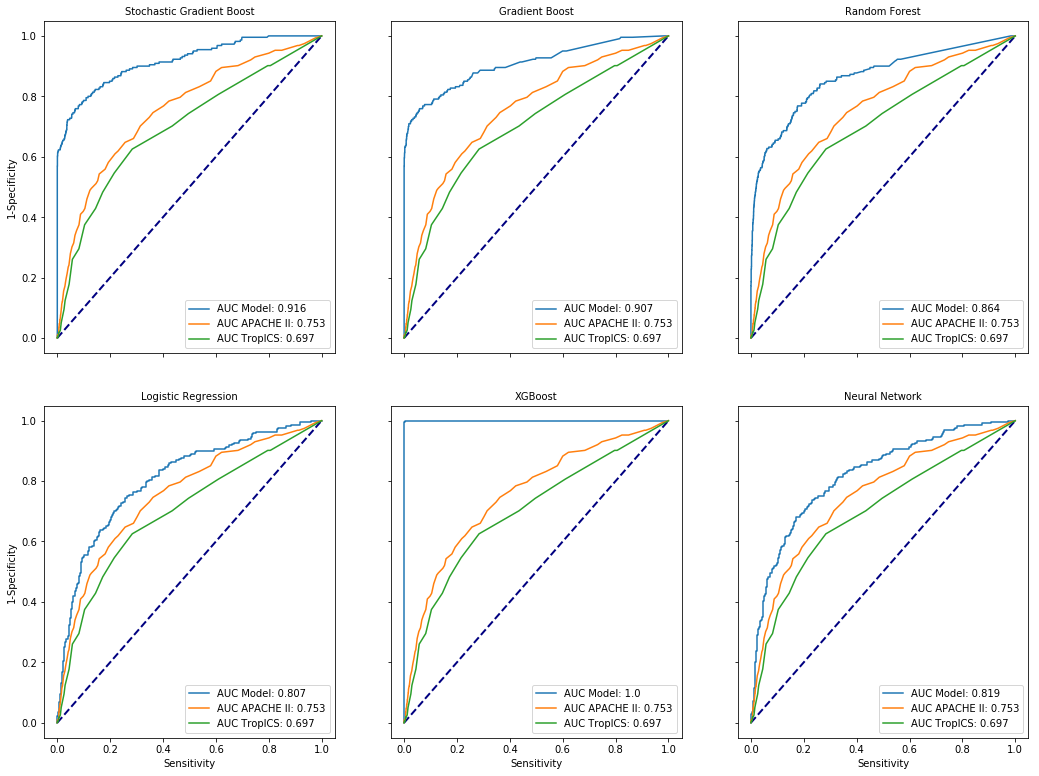

In [667]:
case_tr = preprocess.evaluate(pred_train, targ_train).testPerformance(data_type='train', 
                                                              models=models, ap_tr_list=apache_trop)

Arranging Models...
Evaluating performance...
Preparing dataset...
Evaluating...

Estimator: Stochastic Gradient Boost
Score in training set: 0.7869087612648642
Confidence interval for the score: [0.745 - 0.824]
Optimal threshold in training set is: 0.081
Preparing dataset...
Evaluating...

Estimator: Gradient Boost
Score in training set: 0.7770116781314991
Confidence interval for the score: [0.733 - 0.819]
Optimal threshold in training set is: 0.089
Preparing dataset...
Evaluating...

Estimator: Random Forest
Score in training set: 0.7762864608329334
Confidence interval for the score: [0.730 - 0.819]
Optimal threshold in training set is: 0.066
Preparing dataset...
Evaluating...

Estimator: Logistic Regression
Score in training set: 0.7883218685010398
Confidence interval for the score: [0.745 - 0.826]
Optimal threshold in training set is: 0.092
Preparing dataset...
Evaluating...

Estimator: XGBoost
Score in training set: 0.726241134751773
Confidence interval for the score: [0.673 - 0.7

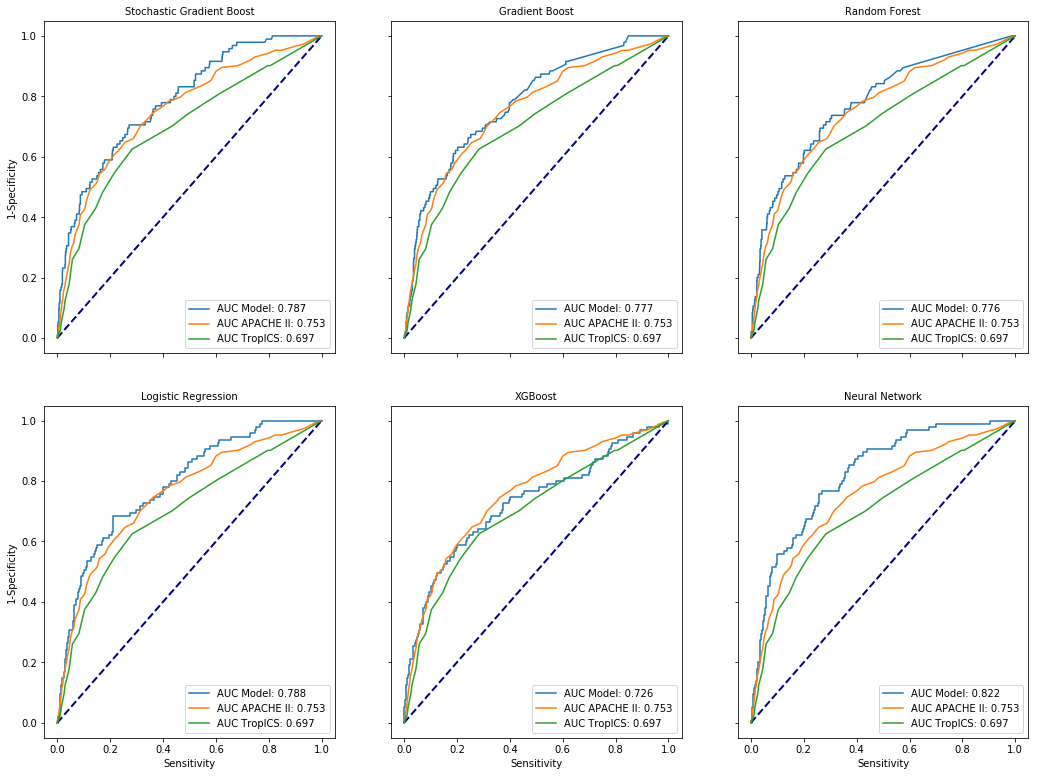

In [668]:
case_ts = preprocess.evaluate(pred_train, targ_train).testPerformance(data_type='test', 
                                                              models=models, ap_tr_list=apache_trop)

Arranging Models...
Evaluating performance...
Preparing dataset...
Evaluating...

Estimator: Stochastic Gradient Boost
Score in training set: 0.8044012785837227
Confidence interval for the score: [0.751 - 0.857]
Optimal threshold in training set is: 0.097
Preparing dataset...
Evaluating...

Estimator: Gradient Boost
Score in training set: 0.8139291861322842
Confidence interval for the score: [0.767 - 0.864]
Optimal threshold in training set is: 0.059
Preparing dataset...
Evaluating...

Estimator: Random Forest
Score in training set: 0.7898020654044752
Confidence interval for the score: [0.739 - 0.843]
Optimal threshold in training set is: 0.107
Preparing dataset...
Evaluating...

Estimator: Logistic Regression
Score in training set: 0.8126383083353824
Confidence interval for the score: [0.759 - 0.863]
Optimal threshold in training set is: 0.07
Preparing dataset...
Evaluating...

Estimator: XGBoost
Score in training set: 0.7432382591590853
Confidence interval for the score: [0.677 - 0.8

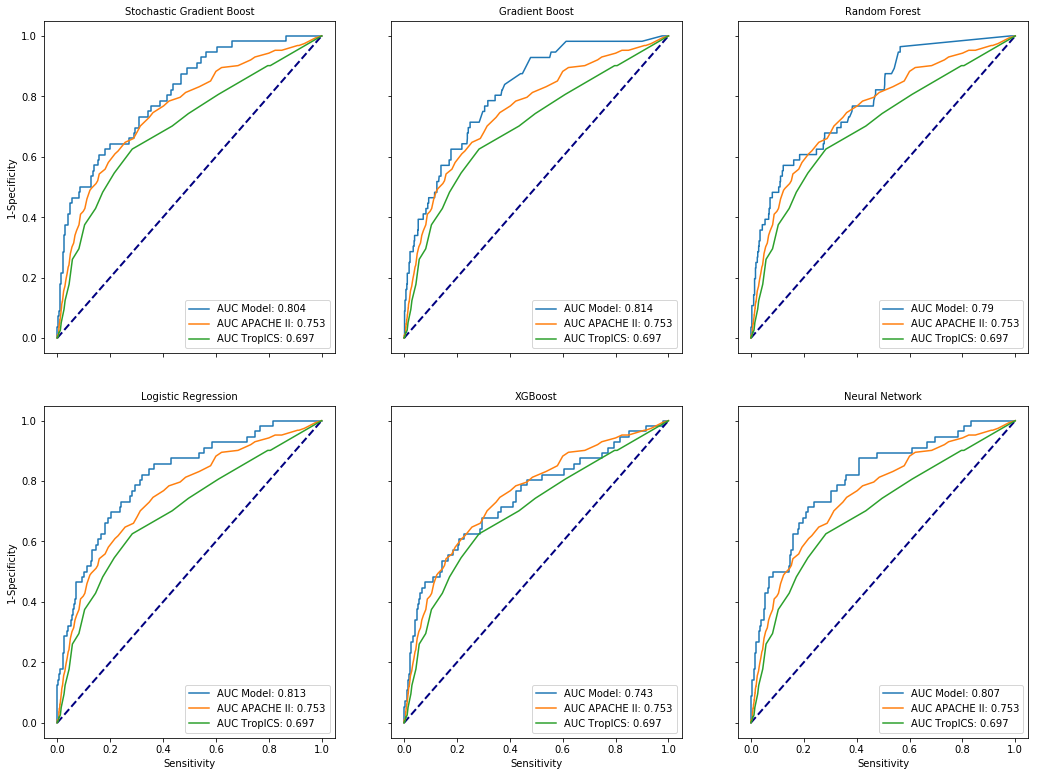

In [669]:
case_h = preprocess.evaluate(pred_h, targ_h).testPerformance(data_type='holdout', 
                                                              models=models, ap_tr_list=apache_trop)

### Calibration in train and holout

Evaluating performance...
Preparing dataset...
Evaluating...

Estimator: Stochastic Gradient Boost
Preparing dataset...
Evaluating...

Estimator: Gradient Boost
Preparing dataset...
Evaluating...

Estimator: Random Forest
Preparing dataset...
Evaluating...

Estimator: Logistic Regression
Preparing dataset...
Evaluating...

Estimator: XGBoost
Preparing dataset...
Evaluating...

Estimator: Neural Network


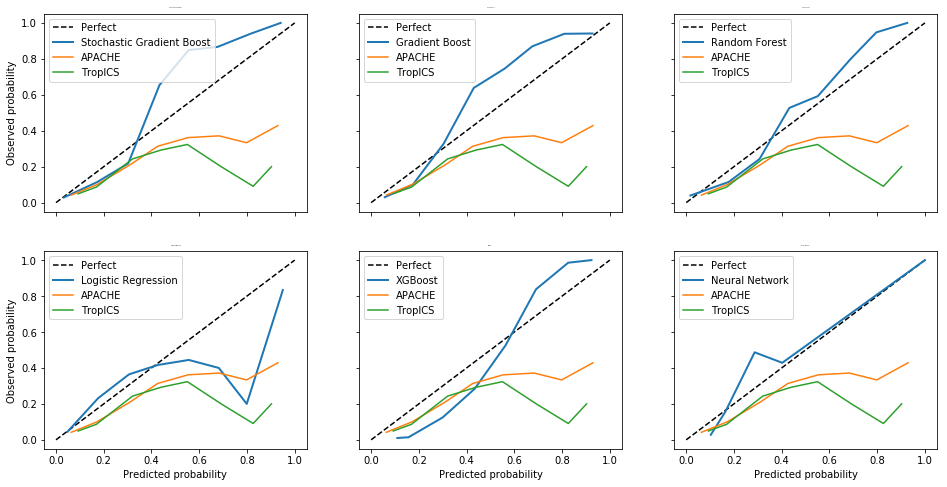

In [670]:
calib_ls_tr = preprocess.Calibration_curves(pred_train, targ_train, data_type='train', 
                              models=models, ap_tr_list=apache_trop).getCalibCurves()

Evaluating performance...
Preparing dataset...
Evaluating...

Estimator: Stochastic Gradient Boost
Preparing dataset...
Evaluating...

Estimator: Gradient Boost
Preparing dataset...
Evaluating...

Estimator: Random Forest
Preparing dataset...
Evaluating...

Estimator: Logistic Regression
Preparing dataset...
Evaluating...

Estimator: XGBoost
Preparing dataset...
Evaluating...

Estimator: Neural Network


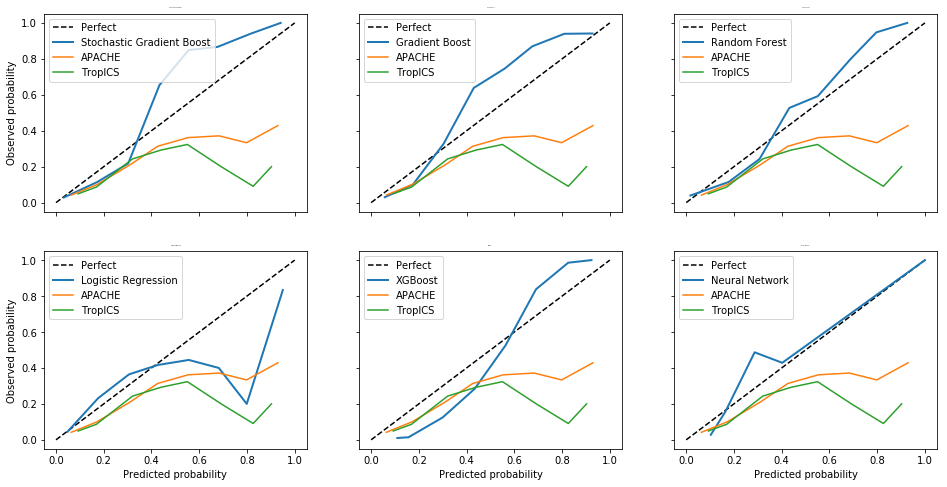

In [671]:
calib_ls_ts = preprocess.Calibration_curves(pred_train, targ_train, data_type='test', 
                              models=models, ap_tr_list=apache_trop).getCalibCurves()

Evaluating performance...
Preparing dataset...
Evaluating...

Estimator: Stochastic Gradient Boost
Preparing dataset...
Evaluating...

Estimator: Gradient Boost
Preparing dataset...
Evaluating...

Estimator: Random Forest
Preparing dataset...
Evaluating...

Estimator: Logistic Regression
Preparing dataset...
Evaluating...

Estimator: XGBoost
Preparing dataset...
Evaluating...

Estimator: Neural Network


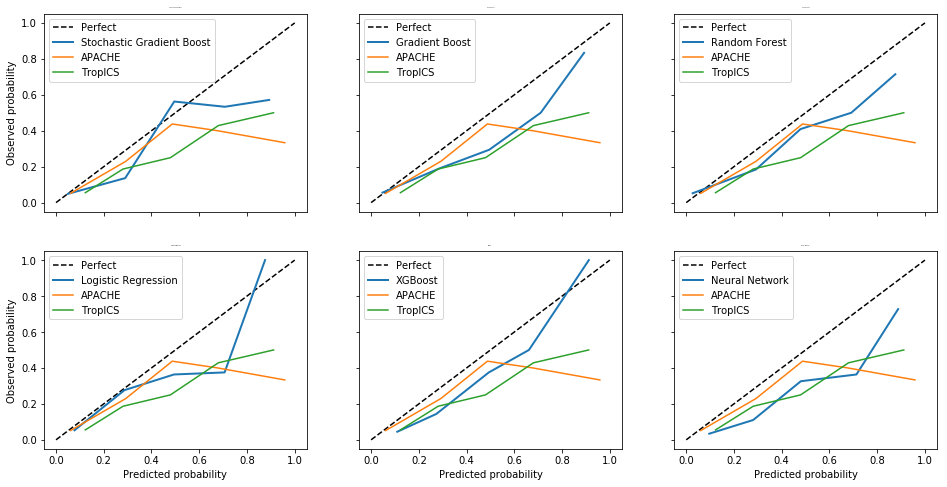

In [672]:
calib_ls_holdout = preprocess.Calibration_curves(pred_h, targ_h, data_type='holdout', 
                              models=models, ap_tr_list=apache_trop_h).getCalibCurves()

## Creating Tables

In [630]:
def getROCString(case, case_type):
    score = (round(case.get(case_type)[1].get('score'), 3))
    lower = (round(case.get(case_type)[2].get('CI')[0], 3))
    upper = (round(case.get(case_type)[2].get('CI')[1], 3))
    string = str(score) + ' (' + str(lower) + '-' + str(upper) + ')'
    return string

In [631]:
def getAUROCdf(train_case, case_type):
    aurocs = []; names = []
    for case in train_case:
        aurocs.append(getROCString(case, case_type))
        names.append(case.get(case_type)[0].get('model'))
    return pd.DataFrame(aurocs, names)

In [632]:
def AUROC_Table(train_case, test_case, holdout_case):
    auroc_train = getAUROCdf(train_case, 'train')
    auroc_test = getAUROCdf(test_case, 'test')
    auroc_holdout = getAUROCdf(holdout_case, 'holdout')
    auroc_table = pd.concat((auroc_train, auroc_test, auroc_holdout), axis=1)
    auroc_table.columns = ['Train', 'Test', 'Holdout']
    return auroc_table

In [633]:
def getSenSpecDf(train_case, case_type):
    sensitivities = []; specificities = []; names = []
    for case in train_case:
        sensitivity = round(case[case_type][3]['CR']['0']['recall']*100, 1)
        specificity = round(case[case_type][3]['CR']['1']['recall']*100, 1)
        sensitivities.append(sensitivity)
        specificities.append(specificity)
        names.append(case.get(case_type)[0].get('model'))
    ss_df = pd.concat((pd.DataFrame(sensitivities, names), pd.DataFrame(specificities, names)), axis=1)
    ss_df.columns = ['Sensitivity {}'.format(case_type), 'Specificity {}'.format(case_type)]
    return ss_df

In [634]:
def Sensitivity_Specificity_Table(train_case, test_case, holdout_case):
    sensp_train = getSenSpecDf(train_case, 'train')
    sensp_test = getSenSpecDf(test_case, 'test')
    sensp_holdout = getSenSpecDf(holdout_case, 'holdout')
    sensp_table = pd.concat((sensp_train, sensp_test, sensp_holdout), axis=1)
    return sensp_table

In [635]:
auroc = AUROC_Table(case_tr, case_ts, case_h)

In [636]:
sensp = Sensitivity_Specificity_Table(case_tr, case_ts, case_h)

In [637]:
auroc.to_csv('AUROC.csv')
sensp.to_csv('SenSpec.csv')

# Training Models
We have created following datasets <br>
* pred_train, targ_train <br>
* pred_h, targ_h <br>
* trop_train, targ_train <br>
* trop_h, targ_h <br>
* ap_train, targ_train <br>
* ap_h, targ_h 

In [621]:
# from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import GradientBoostingRegressor, AdaBoostClassifier, RandomForestClassifier, BaggingRegressor, RandomForestRegressor
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from keras.layers import Dense, Dropout
from keras.models import Sequential
from keras import regularizers
from keras.wrappers.scikit_learn import KerasRegressor
import xgboost as xgb

SEED = 62

# Creating pipes
pipe_lr = Pipeline(steps=[('clf', LogisticRegression(random_state=42))])
pipe_rf = Pipeline(steps=[('clf', RandomForestRegressor(random_state=42))])
pipe_gb = Pipeline(steps=[('clf', GradientBoostingRegressor())])
pipe_sgb = Pipeline(steps=[('clf', GradientBoostingRegressor())])
pipe_xgb = Pipeline(steps=[('clf', xgb.XGBRegressor())])

# Creating params
params_lr = {
    'clf__C' : [0.001, 0.01, 0.1, 1],
    'clf__penalty' : ['l1', 'l2']
}
params_rf = {
    'clf__max_depth' : np.arange(2, 20, 6),
    'clf__max_leaf_nodes': np.arange(2,20,6), 
    'clf__min_impurity_split': [0.01, 0.1],
    'clf__n_estimators': np.arange(50, 70, 10)
}
params_gb = {
    'clf__n_estimators': np.arange(10, 100, 10),
    'clf__learning_rate': [0.01, 0.1, 1], 
    'clf__max_depth': np.arange(1,10,1)
}
params_sgb = {
    'clf__n_estimators': np.arange(10, 100, 10),
    'clf__learning_rate': [0.01, 0.1, 1], 
    'clf__max_depth': np.arange(1,10,1), 
    'clf__subsample': [0.2, 0.4, 0.8], 
    'clf__max_features': [0.2, 0.4, 0.8]
}
params_xgb = {
    'clf__subsample': np.arange(.05, 1, .05),
    'clf__max_depth': np.arange(3,20,1),
    'clf__colsample_bytree': np.arange(.1,1.05,.05) 
}


# Construct grid searches
jobs = -1

gs_lr = RandomizedSearchCV(estimator=pipe_lr, 
                    param_distributions=params_lr,
                    n_iter=5,
                    scoring='roc_auc',
                    cv=5)
grid_rf = RandomizedSearchCV(estimator=pipe_rf, 
                      param_distributions=params_rf, 
                      n_iter=5,
                      scoring='roc_auc', 
                      cv=5)
grid_gb = RandomizedSearchCV(estimator=pipe_gb, 
                      param_distributions=params_gb, 
                      n_iter=5,
                      scoring='roc_auc', 
                      cv=5)
grid_sgb = RandomizedSearchCV(estimator=pipe_sgb, 
                      param_distributions=params_sgb, 
                      n_iter=5,
                      scoring='roc_auc', 
                      cv=5)
grid_xgb = RandomizedSearchCV(estimator=pipe_xgb, 
                      param_distributions=params_xgb, 
                      n_iter=5,
                      scoring='roc_auc', 
                      cv=5)

# List of pipelines
grids = [grid_sgb, grid_gb, grid_rf, gs_lr, grid_xgb, 1]

# Dictionary of pipelines
grid_dict = {0: 'Stochastic Gradient Boost', 1: 'Gradient Boost', 2: 'RandomForestRegressor', 
             3: 'Logistic Regression', 4: 'XGBoost', 5: 'Neural Net'}

# Fitting
print('Performing model optimizations...')

X_train, X_test, y_train, y_test = train_test_split(pred_train, targ_train, test_size=0.3, stratify=targ_train, random_state=62)

for idx, gs in enumerate(grids):
    if (grid_dict[idx] == 'Neural Net'):
        print('\nEstimator: %s' % grid_dict[idx])
        
        # Creating NN model
        nn_model = Sequential()
        nn_model.add(Dense(128, activation='relu', input_shape=(24,)))
        nn_model.add(Dropout(1))
        nn_model.add(Dense(128, activation='relu'))
        nn_model.add(Dropout(1))
        nn_model.add(Dense(128, activation='relu'))
        nn_model.add(Dropout(1))
        nn_model.add(Dense(128, activation='relu'))
        nn_model.add(Dropout(1))
        nn_model.add(Dense(128, activation='relu'))
        nn_model.add(Dropout(1))
        nn_model.add(Dense(128, kernel_regularizer=regularizers.l2(0.1), activation='relu'))
        nn_model.add(Dense(1))
        # Compiling
        nn_model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])
        
        nn_model.fit(pred_train, targ_train)
        y_pred_nn = nn_model.predict(pred_train)
        # Scoring
        print('Train set accuracy score for best param: %.3f ' % roc_auc_score(targ_train, y_pred_nn))
        break
    else:
        print('\nEstimator: %s' % grid_dict[idx])
        # Fit grid search
        gs.fit(X_train, y_train)
        # Best params
        print('Best params: %s' % gs.best_params_)
        # Best training data accuracy
        print('Best training accuracy: %.3f' % gs.best_score_)
        if (grid_dict[idx] == 'Logistic Regression'):
            y_pred = gs.predict_proba(X_test)[:, 1]
        else:
            # Predict on test data with best params
            y_pred = gs.predict(X_test)
        # Test data accuracy of model with best params
        print('Test set accuracy score for best params: %.3f ' % roc_auc_score(y_test, y_pred))

Performing model optimizations...

Estimator: Stochastic Gradient Boost
Best params: {'clf__subsample': 0.8, 'clf__n_estimators': 70, 'clf__max_features': 0.2, 'clf__max_depth': 6, 'clf__learning_rate': 0.01}
Best training accuracy: 0.781
Test set accuracy score for best params: 0.787 

Estimator: Gradient Boost
Best params: {'clf__n_estimators': 20, 'clf__max_depth': 5, 'clf__learning_rate': 0.1}
Best training accuracy: 0.765
Test set accuracy score for best params: 0.777 

Estimator: RandomForestRegressor
Best params: {'clf__n_estimators': 60, 'clf__min_impurity_split': 0.01, 'clf__max_leaf_nodes': 14, 'clf__max_depth': 14}
Best training accuracy: 0.760
Test set accuracy score for best params: 0.776 

Estimator: Logistic Regression
Best params: {'clf__penalty': 'l1', 'clf__C': 0.1}
Best training accuracy: 0.784
Test set accuracy score for best params: 0.788 

Estimator: XGBoost
[17:38:50] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squar

In [622]:
pipe_dtr = Pipeline(steps=[('clf', DecisionTreeRegressor(random_state=42))])
params_dtr = {
    'clf__max_depth' : np.arange(1,20,5),
    'clf__min_samples_leaf' : [0.05, 0.1]
}
gs_dtr = RandomizedSearchCV(estimator=pipe_dtr, 
                    param_distributions=params_dtr,
                    scoring='roc_auc',
                    cv=5)
X_train, X_test, y_train, y_test = train_test_split(pred_train, targ_train, test_size=0.3, 
                                                    stratify=targ_train, random_state=62)
gs_dtr.fit(X_train, y_train)
y_pred = gs_dtr.predict(X_train)

In [640]:
models = [grid_sgb.best_estimator_, grid_gb.best_estimator_, grid_rf.best_estimator_, 
          gs_lr.best_estimator_, grid_xgb.best_estimator_, nn_model]
model_names = ['sgb', 'gb', 'rf', 'lr', 'xgb', 'nn']

In [642]:
import pickle
for idx, model in enumerate(models):
    filename = '{}.sav'.format(model_names[idx])
    pickle.dump(model, open(filename, 'wb'))

Evaluating...

Estimator: Stochastic Gradient Boost
Score in training set: 0.9160896853905973
Evaluating...

Estimator: Gradient Boost
Score in training set: 0.9068458137607074
Evaluating...

Estimator: Random Forest
Score in training set: 0.8637212331741206
Evaluating...

Estimator: Logistic Regression
Score in training set: 0.8069968025895077
Evaluating...

Estimator: XGBoost
Score in training set: 0.9999861840287372
Evaluating...

Estimator: Neural Network
Score in training set: 0.8194351241463704
Evaluating...

Estimator: Stochastic Gradient Boost
Score in training set: 0.8044012785837227
Evaluating...

Estimator: Gradient Boost
Score in training set: 0.8139291861322842
Evaluating...

Estimator: Random Forest
Score in training set: 0.7898020654044752
Evaluating...

Estimator: Logistic Regression
Score in training set: 0.8126383083353824
Evaluating...

Estimator: XGBoost
Score in training set: 0.7432382591590853
Evaluating...

Estimator: Neural Network
Score in training set: 0.80667

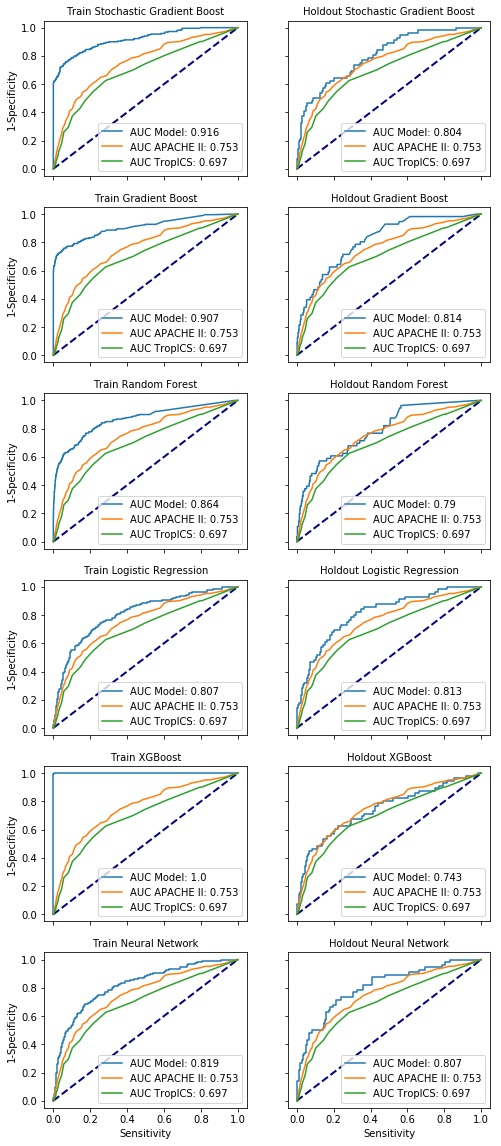

In [49]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

model_dict = {0: 'Stochastic Gradient Boost', 1: 'Gradient Boost', 2: 'Random Forest', 
                        3: 'Logistic Regression', 4: 'XGBoost', 5: 'Neural Network'}
fig, axs = plt.subplots(6, 2)
X_train, X_test, y_train, y_test = train_test_split(pred_train, targ_train, test_size=0.3, 
                                                    stratify=targ_train, random_state=62)
for idx, model in enumerate(models):        
    
    # Evaluating
    print('Evaluating...')
    print('\nEstimator: %s' % model_dict[idx])
    
    # Predict
    if (model_dict[idx] == 'Logistic Regression'):
        y_train_pred = model.predict_proba(X_train)[:, 1]
    else:
        y_train_pred = model.predict(X_train)
    
    # Find ROC Score
    model_score = roc_auc_score(y_train, y_train_pred)
    print('Score in training set: %s' % model_score)
    
    # Finding optimal cut off
    fpr, tpr, thresholds = roc_curve(y_train, y_train_pred)
    
    sur_all = targ_train; ap_all = ap_train; trop_all = trop_train
    fpr_ap, tpr_ap, _ = roc_curve(sur_all, ap_all)
    fpr_tr, tpr_tr, _ = roc_curve(sur_all, trop_all)
    ap_auc = roc_auc_score(sur_all, ap_all)
    tr_auc = roc_auc_score(sur_all, trop_all)

    # Plotting ROCs
    axs[idx, 0].plot(fpr,tpr, label='AUC Model: {}'.format(round(model_score, 3)))
    axs[idx, 0].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    axs[idx, 0].set_title('Train {}'.format(model_dict[idx]), fontsize = 10)
    axs[idx, 0].plot(fpr_ap, tpr_ap, label='AUC APACHE II: {}'.format(round(ap_auc, 3)))
    axs[idx, 0].plot(fpr_tr, tpr_tr, label='AUC TropICS: {}'.format(round(tr_auc, 3)))
    axs[idx, 0].legend(loc='lower right')
    for ax in axs.flat:
        ax.set(xlabel='Sensitivity', ylabel='1-Specificity')
    for ax in axs.flat:
        ax.label_outer()

for idx, model in enumerate(models):        
    # Evaluating
    print('Evaluating...')
    print('\nEstimator: %s' % model_dict[idx])
    X_train = pred_h
    y_train = targ_h
    # Predict
    if (model_dict[idx] == 'Logistic Regression'):
        y_train_pred = model.predict_proba(X_train)[:, 1]
    else:
        y_train_pred = model.predict(X_train)
    
    # Find ROC Score
    model_score = roc_auc_score(y_train, y_train_pred)
    print('Score in training set: %s' % model_score)
    
    # Finding optimal cut off
    fpr, tpr, thresholds = roc_curve(y_train, y_train_pred)
    
    sur_all = targ_train; ap_all = ap_train; trop_all = trop_train
    fpr_ap, tpr_ap, _ = roc_curve(sur_all, ap_all)
    fpr_tr, tpr_tr, _ = roc_curve(sur_all, trop_all)
    ap_auc = roc_auc_score(sur_all, ap_all)
    tr_auc = roc_auc_score(sur_all, trop_all)

    # Plotting ROCs
    axs[idx, 1].plot(fpr,tpr, label='AUC Model: {}'.format(round(model_score, 3)))
    axs[idx, 1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    axs[idx, 1].set_title('Holdout {}'.format(model_dict[idx]), fontsize = 10)
    axs[idx, 1].plot(fpr_ap, tpr_ap, label='AUC APACHE II: {}'.format(round(ap_auc, 3)))
    axs[idx, 1].plot(fpr_tr, tpr_tr, label='AUC TropICS: {}'.format(round(tr_auc, 3)))
    axs[idx, 1].legend(loc='lower right')
    for ax in axs.flat:
        ax.set(xlabel='Sensitivity', ylabel='1-Specificity')
    for ax in axs.flat:
        ax.label_outer()
    fig1 = plt.gcf()
    fig1.set_size_inches(8, 20)
    fig1.savefig('ROC_new.png', dpi=300)
plt.show()

In [1]:
def reliability_curve(y_true, y_score, bins=10, normalize=False):
    
    if normalize:  # Normalize scores into bin [0, 1]
        y_score = (y_score - y_score.min()) / (y_score.max() - y_score.min())

    bin_width = 1.0 / bins
    bin_centers = np.linspace(0, 1.0 - bin_width, bins) + bin_width / 2

    y_score_bin_mean = np.empty(bins)
    empirical_prob_pos = np.empty(bins)
    for i, threshold in enumerate(bin_centers):
        # determine all samples where y_score falls into the i-th bin
        bin_idx = np.logical_and(threshold - bin_width / 2 < y_score,
                                 y_score <= threshold + bin_width / 2)
        # Store mean y_score and mean empirical probability of positive class
        y_score_bin_mean[i] = y_score[bin_idx].mean()
        empirical_prob_pos[i] = y_true[bin_idx].mean()
    return y_score_bin_mean, empirical_prob_pos

Evaluating...

Estimator: Stochastic Gradient Boost
Evaluating...

Estimator: Gradient Boost
Evaluating...

Estimator: Random Forest
Evaluating...

Estimator: Logistic Regression
Evaluating...

Estimator: XGBoost
Evaluating...

Estimator: Neural Network
Evaluating...

Estimator: Stochastic Gradient Boost
Evaluating...

Estimator: Gradient Boost
Evaluating...

Estimator: Random Forest
Evaluating...

Estimator: Logistic Regression
Evaluating...

Estimator: XGBoost
Evaluating...

Estimator: Neural Network


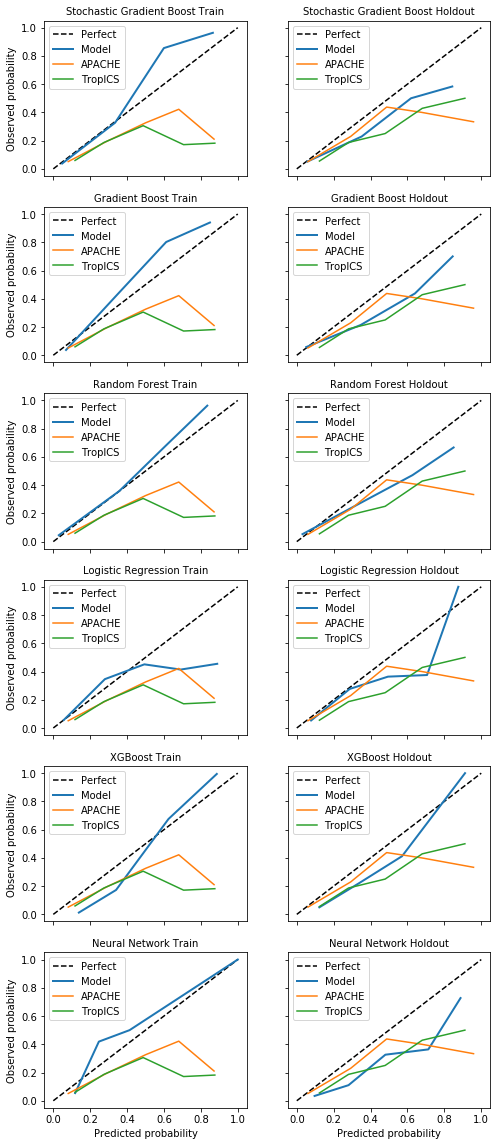

In [46]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

model_dict = {0: 'Stochastic Gradient Boost', 1: 'Gradient Boost', 2: 'Random Forest', 
                        3: 'Logistic Regression', 4: 'XGBoost', 5: 'Neural Network'}
fig, axs = plt.subplots(6, 2)
X_train, X_test, y_train, y_test = train_test_split(pred_train, targ_train, test_size=0.3, 
                                                    stratify=targ_train, random_state=62)
X_train = pred_train
y_train = targ_train
flatten = lambda l: [item for sublist in l for item in sublist]
for idx, model in enumerate(models):        
    trop = trop_train
    ap = ap_train
    n_bins = 5
    print('Evaluating...')
    print('\nEstimator: %s' % model_dict[idx])
    # APACHE values
    ap_score_bin_mean, ap_empirical_prob_pos = reliability_curve(y_train, ap, normalize=True, bins=n_bins)
    ap_scores_not_nan = np.logical_not(np.isnan(ap_empirical_prob_pos))
    # Trop values
    trop_score_bin_mean, trop_empirical_prob_pos = reliability_curve(y_train, trop, normalize=True, bins=n_bins)
    trop_scores_not_nan = np.logical_not(np.isnan(trop_empirical_prob_pos))

    # Predict
    if (model_dict[idx] == 'Logistic Regression'):
        y_score_bin_mean, empirical_prob_pos = reliability_curve(y_train, model.predict_proba(X_train)[:, 1], normalize=True, bins=n_bins)        
    elif (model_dict[idx] == 'Neural Network'):
        y_score_bin_mean, empirical_prob_pos = reliability_curve(y_train, np.array(flatten(model.predict(X_train))), normalize=True, bins=n_bins)
    else:
        y_score_bin_mean, empirical_prob_pos = reliability_curve(y_train, model.predict(X_train), normalize=True, bins=4)

    # Plotting 
    axs[idx, 0].plot([0.0, 1.0], [0.0, 1.0], 'k', label="Perfect", ls='--')
    scores_not_nan = np.logical_not(np.isnan(empirical_prob_pos))
    axs[idx, 0].plot(y_score_bin_mean[scores_not_nan],empirical_prob_pos[scores_not_nan], 
                            label='Model', lw=2)
    axs[idx, 0].plot(ap_score_bin_mean[ap_scores_not_nan],ap_empirical_prob_pos[ap_scores_not_nan], 
                            label='APACHE')
    axs[idx, 0].plot(trop_score_bin_mean[trop_scores_not_nan],trop_empirical_prob_pos[trop_scores_not_nan], 
                            label='TropICS')
    axs[idx, 0].set_title('{} Train'.format(model_dict[idx]), fontsize = 10)
    axs[idx, 0].legend(loc='upper left')

    for ax in axs.flat:
        ax.set(xlabel='Predicted probability', ylabel='Observed probability')
    for ax in axs.flat:
        ax.label_outer()
        
X_train = pred_h
y_train = targ_h
flatten = lambda l: [item for sublist in l for item in sublist]
for idx, model in enumerate(models):        
    trop = trop_h
    ap = ap_h
    print('Evaluating...')
    print('\nEstimator: %s' % model_dict[idx])
    # APACHE values
    ap_score_bin_mean, ap_empirical_prob_pos = reliability_curve(y_train, ap, normalize=True, bins=n_bins)
    ap_scores_not_nan = np.logical_not(np.isnan(ap_empirical_prob_pos))
    # Trop values
    trop_score_bin_mean, trop_empirical_prob_pos = reliability_curve(y_train, trop, normalize=True, bins=n_bins)
    trop_scores_not_nan = np.logical_not(np.isnan(trop_empirical_prob_pos))

    # Predict
    if (model_dict[idx] == 'Logistic Regression'):
        y_score_bin_mean, empirical_prob_pos = reliability_curve(y_train, model.predict_proba(X_train)[:, 1], normalize=True, bins=n_bins)        
    elif (model_dict[idx] == 'Neural Network'):
        y_score_bin_mean, empirical_prob_pos = reliability_curve(y_train, np.array(flatten(model.predict(X_train))), normalize=True, bins=n_bins)
    else:
        y_score_bin_mean, empirical_prob_pos = reliability_curve(y_train, model.predict(X_train), normalize=True, bins=4)

    # Plotting 
    axs[idx, 1].plot([0.0, 1.0], [0.0, 1.0], 'k', label="Perfect", ls='--')
    scores_not_nan = np.logical_not(np.isnan(empirical_prob_pos))
    axs[idx, 1].plot(y_score_bin_mean[scores_not_nan],empirical_prob_pos[scores_not_nan], 
                            label='Model', lw=2)
    axs[idx, 1].plot(ap_score_bin_mean[ap_scores_not_nan],ap_empirical_prob_pos[ap_scores_not_nan], 
                            label='APACHE')
    axs[idx, 1].plot(trop_score_bin_mean[trop_scores_not_nan],trop_empirical_prob_pos[trop_scores_not_nan], 
                            label='TropICS')
    axs[idx, 1].set_title('{} Holdout'.format(model_dict[idx]), fontsize = 10)
    axs[idx, 1].legend(loc='upper left')

    for ax in axs.flat:
        ax.set(xlabel='Predicted probability', ylabel='Observed probability')
    for ax in axs.flat:
        ax.label_outer()

    fig1 = plt.gcf()
    fig1.set_size_inches(8, 20)
    fig1.savefig('Calib_new.png', dpi=300)